# Test of Find PSF Candidates

This notebook tests an algorithm that first finds hot pixels by demanding that they
(a) exceed a threshold and (b) be brighter than their four nearest neighbors. These 
are the &ldquo;hot pixel leaders.&rdquo

Then it culls the hot pixel leaders whose neighbors fall off too sharply using the following
quick criterion for non-PSF-shaped regions: any hot pixel leader that has a neighbor <20% of
the peak is not a PSF candidate.

## Create the Test Data

In [1]:
# THIS COMMENT IS THE LONGEST A LINE CAN BE AND STILL RENDER COMPLETELY WHEN PRINTING IN LANDSCAPE MODE.

import numpy as np
import matplotlib.pyplot as plt
from math import floor
%matplotlib inline

from collections import namedtuple

Pixel = namedtuple('Pixel', 'x y value')
PSFCandidate = namedtuple('PSFCandidate', 'center neighbors')

TEST_DATA_WIDTH = 6
TEST_DATA_HEIGHT = 4

TEST_DATA = np.zeros((TEST_DATA_HEIGHT, TEST_DATA_WIDTH))

NON_ZERO_PIXELS = [
    [0, 0, 275],
    [4, 0, 50],
    [0, 1, 300], # PSF candidate!
    [1, 1, 250],
    [3, 1, 175],
    [4, 1, 275], # A hot pixel leader that is not a candidate
    [5, 1, 125],
    [0, 2, 175],
    [1, 2, 175],
    [4, 2, 250],
    [5, 2, 200],
    [0, 3, 25],
    [1, 3, 250], # A hot pixel leader that is not a candidate
    [3, 3, 25],
    [4, 3, 200],
    [5, 3, 225], # PSF candidate!
]

for row in NON_ZERO_PIXELS:
    TEST_DATA[row[1], row[0]] = row[2]


## Routines for Finding the Hot Pixel Leaders

In [2]:
def is_winner_or_tied(candidate_leader, i, j, data):
    return candidate_leader.value >= data[j, i]

def is_leader(candidate_leader, data):
    data_height, data_width = data.shape
    for offset_y, offset_x in [(-1, 0), (0, 1), (1, 0), (0, -1)]:
        j = floor(candidate_leader.y + offset_y)
        i = floor(candidate_leader.x + offset_x)
        if j < 0 or j >= data_height or i < 0 or i >= data_width:
            continue
        if not is_winner_or_tied(candidate_leader, i, j, data):
            return False
    return True

def find_hot_pixel_leaders(data, threshold):
    # first we simply find all the hot pixels
    data_height, data_width = data.shape
    exceedances = data > threshold  # an array of true-false values
    values_of_exceedances = data[exceedances]
    exceedance_indices = np.nonzero(exceedances)  # a crafty way of getting the indices of the exceedances
    # all of the hot pixels are candidate leaders
    candidate_leaders = np.transpose([exceedance_indices[1], exceedance_indices[0], values_of_exceedances])
    leaders = []
    for i in range(candidate_leaders.shape[0]):
        row = candidate_leaders[i]
        candidate_leader = Pixel(row[0], row[1], row[2])
        if is_leader(candidate_leader, data):
            leaders.append(candidate_leader)
    return leaders


## Find the Hot Pixel Leaders

In [3]:
hot_pixel_leaders = find_hot_pixel_leaders(TEST_DATA, 200)


## The Routines for Finding the PSF Candidates

In [4]:
def is_too_discontinuous(candidate_psf, i, j, data, ratio):
    return data[j, i] < ratio * candidate_psf.value 

def is_candidate_psf(candidate_psf, data, ratio):
    data_height, data_width = data.shape
    for offset_y, offset_x in [(-1, 0), (0, 1), (1, 0), (0, -1)]:
        j = floor(candidate_psf.y + offset_y)
        i = floor(candidate_psf.x + offset_x)
        if j < 0 or j >= data_height or i < 0 or i >= data_width:
            continue
        if is_too_discontinuous(candidate_psf, i, j, data, ratio):
            return False
    return True

def find_psf_candidates(leaders, data, ratio):
    candidates = [leader for leader in leaders if is_candidate_psf(leader, data, ratio)]
    return candidates


## Find the PSF Candidates

In [5]:
candidates = find_psf_candidates(hot_pixel_leaders, TEST_DATA, 0.2)


## Display the Candidates

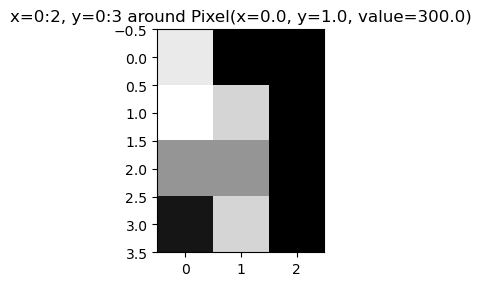

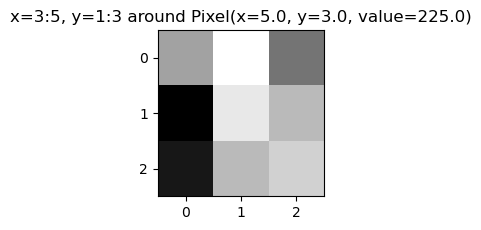

In [6]:
def display_candidate(candidate, data):

    lower_x = floor(candidate.x - 2)
    upper_x = floor(lower_x + 5)
    slice_x = slice(lower_x, upper_x)
    lower_y = floor(candidate.y - 2)
    upper_y = floor(lower_y + 5)
    slice_y = slice(lower_y, upper_y)
    
    fig_size_x = 4
    fig_size_y = 4
    
    # a bit of fussy code for dealing with display near the edges
    
    if (lower_x < 0):
        lower_x = 0
        fig_size_x *= upper_x / 5
    elif (upper_x > 6):
        upper_x = 6
        fig_size_x *= (6 - lower_x) / 5

        
    if (lower_y < 0):
        lower_y = 0
        fig_size_y *= upper_y / 5
    elif (upper_y > 4):
        upper_y = 4
        fig_size_y *= (4 - lower_y) / 5

    fig, axes = plt.subplots(1, 1, figsize=(fig_size_x, fig_size_y))

    title = "x={}:{}, y={}:{} around {}".format(lower_x, upper_x - 1, lower_y, upper_y - 1, candidate)
    
    subframe = data[lower_y:upper_y, lower_x:upper_x]
    
    axes.imshow(subframe, cmap='gray')
    axes.set_title(title, fontsize=12)
    plt.tight_layout()
    plt.show()

    
for candidate in candidates:
    display_candidate(candidate, TEST_DATA)
